In [242]:
import os, os.path
from scipy import stats, special, misc
import fitsio
import extreme_deconvolution
from apogee.spec.plot import apStarWavegrid
import apogee.tools.read as apread
%pylab inline
from galpy.util import bovy_plot
from matplotlib import colors
import seaborn as sns
sns.set_style({'xtick.direction': u'in',
               'ytick.direction': u'in',
               'axes.labelsize': 18.0,
               'axes.titlesize': 18.0,
               'figure.figsize': array([ 6.64,  4.  ]),
               'grid.linewidth': 2.0,
               'legend.fontsize': 18.0,
               'lines.linewidth': 2.0,
               'lines.markeredgewidth': 0.0,
               'lines.markersize': 14.0,
               'patch.linewidth': 0.6,
               'xtick.labelsize': 16.0,
               'xtick.major.pad': 14.0,
               'xtick.major.width': 2.0,
               'xtick.minor.width': 1.0,
               'ytick.labelsize': 16.0,
               'ytick.major.pad': 14.0,
               'ytick.major.width': 2.0,})

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# What are good groupings of LSFs to use for the APOGEE analysis?

## How much do the LSFs vary?

Some code to load the pre-calculated LSFs for all fibers:

In [3]:
def loadLSF(fiber):
    return fitsio.read(os.path.join(os.getenv('DATADIR'),'spectral-tagging','lsf',
                                    'apogee-lsf-dr12-%03i.fits' % fiber))

In [5]:
allLSFs= []
for fiber in range(1,301):
    allLSFs.append(loadLSF(fiber))

In [82]:
xlsf= numpy.linspace(-7.,7.,43) 
def fwhm(lsf):
    if len(lsf.shape) > 1:
        return [(numpy.interp(0.5*tlsf[21],tlsf[::-1][:20],xlsf[::-1][:20])-
                 numpy.interp(0.5*tlsf[21],tlsf[:20],xlsf[:20]))
                for tlsf in lsf]
    else:
        return (numpy.interp(0.5*lsf[21],lsf[::-1][:20],xlsf[::-1][:20])-
                numpy.interp(0.5*lsf[21],lsf[:20],xlsf[:20]))

Let's first look at how much the LSF changes as a function of wavelength

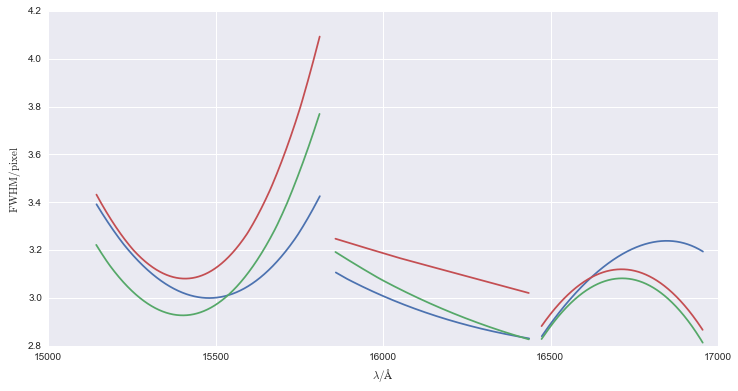

In [83]:
figsize(12,6)
plot(apStarWavegrid(),fwhm(allLSFs[49][::3]))
plot(apStarWavegrid(),fwhm(allLSFs[149][::3]))
plot(apStarWavegrid(),fwhm(allLSFs[249][::3]))
xlabel(r'$\lambda/\AA$')
ylabel(r'$\mathrm{FWHM/pixel}$')

They vary quite a bit (the increase at the blue end is probably not real and is improved in the r6 reduction), but they vary similarly, so we'll just use one wavelength / detector. Those used in Figure 16 in Nidever et al. (2015) are

In [87]:
pix_blue= int(round(numpy.interp(15450.,apStarWavegrid(),numpy.arange(8575))))
pix_green= int(round(numpy.interp(16130.,apStarWavegrid(),numpy.arange(8575))))
pix_red= int(round(numpy.interp(16740.,apStarWavegrid(),numpy.arange(8575))))
print pix_blue, pix_green, pix_red

1655 4772 7459


In [89]:
fwhm_blue= numpy.array([fwhm(allLSFs[ll][::3][pix_blue]) for ll in range(300)])
fwhm_green= numpy.array([fwhm(allLSFs[ll][::3][pix_green]) for ll in range(300)])
fwhm_red= numpy.array([fwhm(allLSFs[ll][::3][pix_red]) for ll in range(300)])

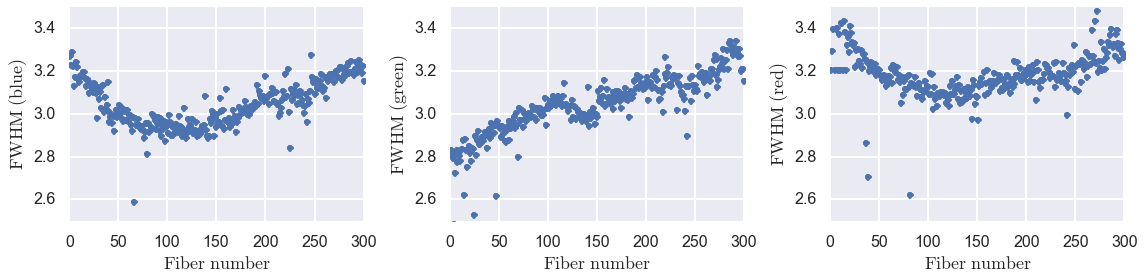

In [269]:
figsize(16,4)
subplot(1,3,1)
bovy_plot.bovy_plot(numpy.arange(1,301),fwhm_blue,'.',
                    gcf=True,
                   yrange=[2.5,3.5],
                   xrange=[0.,301.],
                   xlabel=r'$\mathrm{Fiber\ number}$',
                   ylabel=r'$\mathrm{FWHM\ (blue)}$')
subplot(1,3,2)
bovy_plot.bovy_plot(numpy.arange(1,301),fwhm_green,'.',
                    gcf=True,
                   yrange=[2.5,3.5],
                   xrange=[0.,301.],
                   xlabel=r'$\mathrm{Fiber\ number}$',
                   ylabel=r'$\mathrm{FWHM\ (green)}$')
subplot(1,3,3)
bovy_plot.bovy_plot(numpy.arange(1,301),fwhm_red,'.',
                    gcf=True,
                   yrange=[2.5,3.5],
                   xrange=[0.,301.],
                   xlabel=r'$\mathrm{Fiber\ number}$',
                   ylabel=r'$\mathrm{FWHM\ (red)}$')
tight_layout()

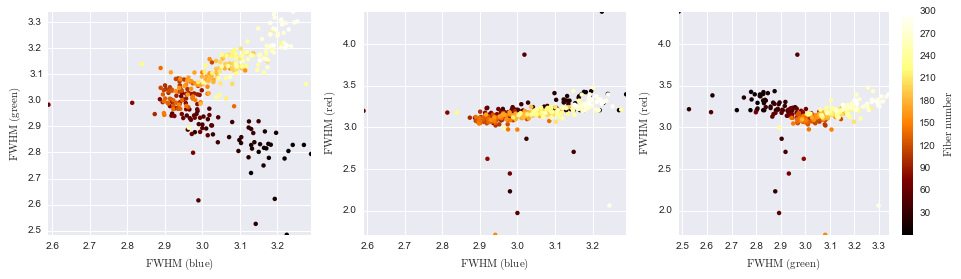

In [100]:
figsize(16,4)
subplot(1,3,1)
bovy_plot.bovy_plot(fwhm_blue,fwhm_green,c=numpy.arange(1,301),
                    edgecolor='none',scatter=True,
                    gcf=True,
                    cmap='afmhot',
                    xlabel=r'$\mathrm{FWHM\ (blue)}$',
                    ylabel=r'$\mathrm{FWHM\ (green)}$')
subplot(1,3,2)
bovy_plot.bovy_plot(fwhm_blue,fwhm_red,c=numpy.arange(1,301),
                    edgecolor='none',scatter=True,
                    gcf=True,
                    cmap='afmhot',
                    xlabel=r'$\mathrm{FWHM\ (blue)}$',
                    ylabel=r'$\mathrm{FWHM\ (red)}$')
subplot(1,3,3)
bovy_plot.bovy_plot(fwhm_green,fwhm_red,c=numpy.arange(1,301),
                    edgecolor='none',scatter=True,
                    gcf=True,
                    colorbar=True,cmap='afmhot',
                    xlabel=r'$\mathrm{FWHM\ (green)}$',
                    ylabel=r'$\mathrm{FWHM\ (red)}$',
                    clabel=r'$\mathrm{Fiber\ number}$')

# How much does the LSF between different visits typically vary?

Let's calculate the typical difference in FWHM for the visits going into a combined spectrum, for a random subset of allStar

In [132]:
allStar= apread.allStar(raw=True)
random_subindx= numpy.random.permutation(len(allStar))[:10000]
allStar= allStar[random_subindx]

In [133]:
allVisit= apread.allVisit(raw=True)

In [146]:
contributing_LSFs= []
for ii in range(len(allStar)):
    this_contributing_LSFs= []
    for jj in range(allStar['NVISITS'][ii]):
        this_contributing_LSFs.append(allVisit[allStar['VISIT_PK'][ii,jj]]['FIBERID'])
    contributing_LSFs.append(this_contributing_LSFs)

In [147]:
fwhm_dispersion_in_combined_blue= [numpy.std([fwhm(allLSFs[fib-1][::3][pix_blue]) for fib in contributing_LSF]) 
                                   for contributing_LSF in contributing_LSFs]
fwhm_dispersion_in_combined_green= [numpy.std([fwhm(allLSFs[fib-1][::3][pix_green]) for fib in contributing_LSF]) 
                                   for contributing_LSF in contributing_LSFs]
fwhm_dispersion_in_combined_red= [numpy.std([fwhm(allLSFs[fib-1][::3][pix_red]) for fib in contributing_LSF]) 
                                   for contributing_LSF in contributing_LSFs]

Now we show the distribution of dispersion in FWHM in the blue, green, and red compared to the total dispersion in FWHM for all fibers

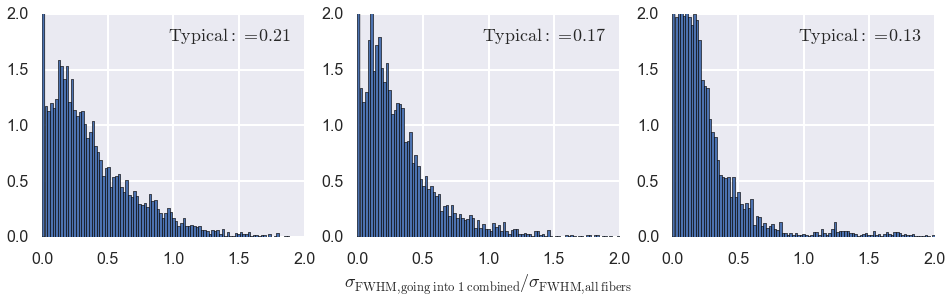

In [149]:
figsize(16,4)
subplot(1,3,1)
dum= hist(fwhm_dispersion_in_combined_blue/numpy.std(fwhm_blue),range=[0.,2.],
    bins=101,normed=True)
bovy_plot.bovy_text(r'$\mathrm{Typical:}\ = %.2f$' % (numpy.median(fwhm_dispersion_in_combined_blue/numpy.std(fwhm_blue))),
                   top_right=True,size=18.)
ylim(0.,2.)
subplot(1,3,2)
dum= hist(fwhm_dispersion_in_combined_green/numpy.std(fwhm_green),range=[0.,2.],
    bins=101,normed=True)
xlabel(r'$\sigma_\mathrm{FWHM,going\ into\ 1\ combined} / \sigma_\mathrm{FWHM, all\ fibers}$')
ylim(0.,2.)
bovy_plot.bovy_text(r'$\mathrm{Typical:}\ = %.2f$' % (numpy.median(fwhm_dispersion_in_combined_green/numpy.std(fwhm_green))),
                   top_right=True,size=18.)
subplot(1,3,3)
dum= hist(fwhm_dispersion_in_combined_red/numpy.std(fwhm_red),range=[0.,2.],
    bins=101,normed=True)
ylim(0.,2.)
bovy_plot.bovy_text(r'$\mathrm{Typical:}\ = %.2f$' % (numpy.median(fwhm_dispersion_in_combined_red/numpy.std(fwhm_red))),
                   top_right=True,size=18.)

Thus, the typical dispersion in FWHM of the visits going into a combined spectrum is <~ 0.2 of the total dispersion in FWHM. The actual typical dispersion is

In [332]:
print numpy.median(fwhm_dispersion_in_combined_blue), \
    numpy.median(fwhm_dispersion_in_combined_green), \
    numpy.median(fwhm_dispersion_in_combined_red)

0.0218630667117 0.0233726092421 0.0252184966477


## Determining good groupings

Let's now run a clustering analysis on the LSFs to determine good groupings. We'll use *extreme deconvolution* to perform Gaussian clustering. Setup the LSF data for the clustering, using as the *random error* the typical dispersion in FWHM of a combined visit, and write a function to run the clustering algorithm:

In [153]:
ydata= numpy.vstack([fwhm_blue,fwhm_green,fwhm_red]).T
ycovar= numpy.ones_like(ydata)
ycovar[:,0]= numpy.median(fwhm_dispersion_in_combined_blue)**2.
ycovar[:,1]= numpy.median(fwhm_dispersion_in_combined_green)**2.
ycovar[:,2]= numpy.median(fwhm_dispersion_in_combined_red)**2.

In [169]:
def run_xd(ngauss,ydata,ycovar):
    # Setup the fit
    xamp= numpy.ones(ngauss)/float(ngauss)
    xmean= numpy.zeros((ngauss,ydata.shape[1]))
    xcovar= numpy.zeros((ngauss,ydata.shape[1],ydata.shape[1]))
    for ii in range(ngauss):
        xmean[ii]= numpy.median(ydata,axis=0)+numpy.random.normal(size=ydata.shape[1])*numpy.std(ydata,axis=0)/10.
        xcovar[ii]= numpy.cov(ydata,rowvar=0)
    lnl= extreme_deconvolution.extreme_deconvolution(ydata,ycovar,xamp,xmean,xcovar)
    return (lnl,xamp,xmean,xcovar)

We can determine a good number of groupings using leave-a-subset-out-cross-validation. We write a function to compute the cross-validation likelihood and set a part of the fibers aside as a test set:

In [179]:
def crossval_lnl(ngauss,ydata_train,ycovar_train,ydata_test,ycovar_test):
    # Function to fit the Gaussian mixture to a subset (_train) and evaluate the likelihood of _test
    xdlnl, xamp, xmean, xcovar= run_xd(ngauss,ydata_train,ycovar_train)
    return extreme_deconvolution.extreme_deconvolution(ydata,ycovar,xamp,xmean,xcovar,likeonly=True)

In [180]:
permIndx= numpy.random.permutation(300)
ydata_train= ydata[permIndx[:240]]
ycovar_train= ycovar[permIndx[:240]]
ydata_test= ydata[permIndx[240:]]
ycovar_test= ycovar[permIndx[240:]]

In [186]:
cval_lnl= [crossval_lnl(ng,ydata_train,ycovar_train,ydata_test,ycovar_test) for ng in range(1,16)]

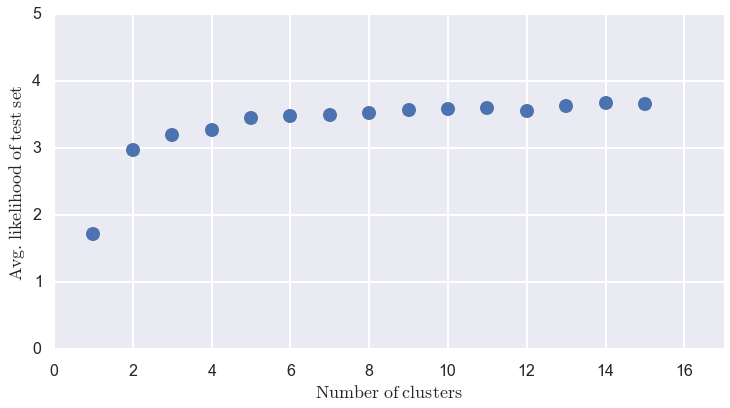

In [187]:
figsize(12,6)
bovy_plot.bovy_plot(range(1,len(cval_lnl)+1),cval_lnl,'o',
                    xrange=[0,len(cval_lnl)+2],
                    yrange=[0.,5.],
                   xlabel=r'$\mathrm{Number\ of\ clusters}$',
                   ylabel=r'$\mathrm{Avg.\ likelihood\ of\ test\ set}$')

It seems like with 5 clusters most of the variation in the LSF can be explained. Let's look at that solution:

# Using 5 groups

In [325]:
lnl, xamp, xmean, xcovar= run_xd(5,ydata,ycovar)
print lnl

3.52564699734


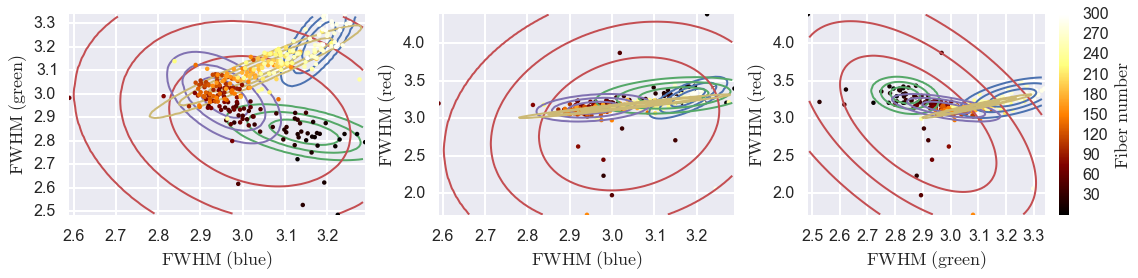

In [326]:
figsize(16,4)
subplot(1,3,1)
bovy_plot.bovy_plot(fwhm_blue,fwhm_green,c=numpy.arange(1,301),
                    edgecolor='none',scatter=True,
                    gcf=True,
                    cmap='afmhot',
                    xlabel=r'$\mathrm{FWHM\ (blue)}$',
                    ylabel=r'$\mathrm{FWHM\ (green)}$',
                   zorder=10)
x, y = np.mgrid[xlim()[0]:xlim()[1]:.01,ylim()[0]:ylim()[1]:.01]
pos = np.dstack((x, y))
for gg in range(len(xmean)):
    nm= stats.multivariate_normal(mean=xmean[gg,:2],cov=xcovar[gg,:2,:2])
    bovy_plot.bovy_dens2d(nm.pdf(pos).T,origin='lower',
                          xrange=[numpy.amin(x),numpy.amax(x)],
                          yrange=[numpy.amin(y),numpy.amax(y)],
                          justcontours=True,overplot=True,
                          cntrmass=True,
                          levels=special.erf(numpy.arange(1,4)/numpy.sqrt(2.)),
                          cntrcolors=colors.rgb2hex(sns.color_palette()[gg]),
                          zorder=gg)
subplot(1,3,2)
bovy_plot.bovy_plot(fwhm_blue,fwhm_red,c=numpy.arange(1,301),
                    edgecolor='none',scatter=True,
                    gcf=True,
                    cmap='afmhot',
                    xlabel=r'$\mathrm{FWHM\ (blue)}$',
                    ylabel=r'$\mathrm{FWHM\ (red)}$')
x, y = np.mgrid[xlim()[0]:xlim()[1]:.01,ylim()[0]:ylim()[1]:.01]
pos = np.dstack((x, y))
for gg in range(len(xmean)):
    nm= stats.multivariate_normal(mean=xmean[gg,::2],cov=xcovar[gg,::2,::2])
    bovy_plot.bovy_dens2d(nm.pdf(pos).T,origin='lower',
                          xrange=[numpy.amin(x),numpy.amax(x)],
                          yrange=[numpy.amin(y),numpy.amax(y)],
                          justcontours=True,overplot=True,
                          cntrmass=True,
                          levels=special.erf(numpy.arange(1,4)/numpy.sqrt(2.)),
                          cntrcolors=colors.rgb2hex(sns.color_palette()[gg]),
                          zorder=gg)
subplot(1,3,3)
bovy_plot.bovy_plot(fwhm_green,fwhm_red,c=numpy.arange(1,301),
                    edgecolor='none',scatter=True,
                    gcf=True,
                    colorbar=True,cmap='afmhot',
                    xlabel=r'$\mathrm{FWHM\ (green)}$',
                    ylabel=r'$\mathrm{FWHM\ (red)}$',
                    clabel=r'$\mathrm{Fiber\ number}$')
x, y = np.mgrid[xlim()[0]:xlim()[1]:.01,ylim()[0]:ylim()[1]:.01]
pos = np.dstack((x, y))
for gg in range(len(xmean)):
    nm= stats.multivariate_normal(mean=xmean[gg,1:],cov=xcovar[gg,1:,1:])
    bovy_plot.bovy_dens2d(nm.pdf(pos).T,origin='lower',
                          xrange=[numpy.amin(x),numpy.amax(x)],
                          yrange=[numpy.amin(y),numpy.amax(y)],
                          justcontours=True,overplot=True,
                          cntrmass=True,
                          levels=special.erf(numpy.arange(1,4)/numpy.sqrt(2.)),
                          cntrcolors=colors.rgb2hex(sns.color_palette()[gg]),
                          zorder=gg)
tight_layout()

Now we compute assignments of fibers to clusters:

In [327]:
prob= numpy.empty((300,len(xmean)))
for gg in range(len(xmean)):
    for ii in range(300):
        nm= stats.multivariate_normal(mean=xmean[gg],cov=xcovar[gg]+ycovar[ii])
        prob[ii,gg]= numpy.log(xamp[gg])+nm.logpdf(ydata[ii])
for ii in range(300): prob[ii]-= misc.logsumexp(prob[ii])
prob= numpy.exp(prob)
assigned= [numpy.arange(len(xmean))[numpy.argmax(p)] for p in prob]

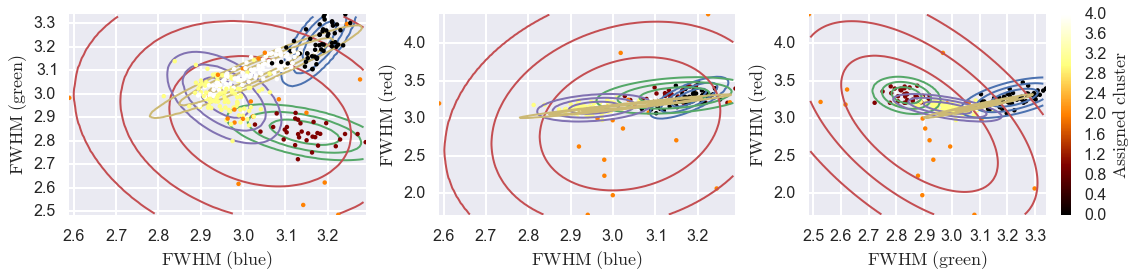

In [328]:
figsize(16,4)
subplot(1,3,1)
bovy_plot.bovy_plot(fwhm_blue,fwhm_green,c=assigned,
                    edgecolor='none',scatter=True,
                    gcf=True,
                    cmap='afmhot',
                    xlabel=r'$\mathrm{FWHM\ (blue)}$',
                    ylabel=r'$\mathrm{FWHM\ (green)}$',
                   zorder=10)
x, y = np.mgrid[xlim()[0]:xlim()[1]:.01,ylim()[0]:ylim()[1]:.01]
pos = np.dstack((x, y))
for gg in range(len(xmean)):
    nm= stats.multivariate_normal(mean=xmean[gg,:2],cov=xcovar[gg,:2,:2])
    bovy_plot.bovy_dens2d(nm.pdf(pos).T,origin='lower',
                          xrange=[numpy.amin(x),numpy.amax(x)],
                          yrange=[numpy.amin(y),numpy.amax(y)],
                          justcontours=True,overplot=True,
                          cntrmass=True,
                          levels=special.erf(numpy.arange(1,4)/numpy.sqrt(2.)),
                          cntrcolors=colors.rgb2hex(sns.color_palette()[gg]),
                          zorder=gg)
subplot(1,3,2)
bovy_plot.bovy_plot(fwhm_blue,fwhm_red,c=assigned,
                    edgecolor='none',scatter=True,
                    gcf=True,
                    cmap='afmhot',
                    xlabel=r'$\mathrm{FWHM\ (blue)}$',
                    ylabel=r'$\mathrm{FWHM\ (red)}$')
x, y = np.mgrid[xlim()[0]:xlim()[1]:.01,ylim()[0]:ylim()[1]:.01]
pos = np.dstack((x, y))
for gg in range(len(xmean)):
    nm= stats.multivariate_normal(mean=xmean[gg,::2],cov=xcovar[gg,::2,::2])
    bovy_plot.bovy_dens2d(nm.pdf(pos).T,origin='lower',
                          xrange=[numpy.amin(x),numpy.amax(x)],
                          yrange=[numpy.amin(y),numpy.amax(y)],
                          justcontours=True,overplot=True,
                          cntrmass=True,
                          levels=special.erf(numpy.arange(1,4)/numpy.sqrt(2.)),
                          cntrcolors=colors.rgb2hex(sns.color_palette()[gg]),
                          zorder=gg)
subplot(1,3,3)
bovy_plot.bovy_plot(fwhm_green,fwhm_red,c=assigned,
                    edgecolor='none',scatter=True,
                    gcf=True,
                    colorbar=True,cmap='afmhot',
                    xlabel=r'$\mathrm{FWHM\ (green)}$',
                    ylabel=r'$\mathrm{FWHM\ (red)}$',
                    clabel=r'$\mathrm{Assigned\ cluster}$')
x, y = np.mgrid[xlim()[0]:xlim()[1]:.01,ylim()[0]:ylim()[1]:.01]
pos = np.dstack((x, y))
for gg in range(len(xmean)):
    nm= stats.multivariate_normal(mean=xmean[gg,1:],cov=xcovar[gg,1:,1:])
    bovy_plot.bovy_dens2d(nm.pdf(pos).T,origin='lower',
                          xrange=[numpy.amin(x),numpy.amax(x)],
                          yrange=[numpy.amin(y),numpy.amax(y)],
                          justcontours=True,overplot=True,
                          cntrmass=True,
                          levels=special.erf(numpy.arange(1,4)/numpy.sqrt(2.)),
                          cntrcolors=colors.rgb2hex(sns.color_palette()[gg]),
                          zorder=gg)
tight_layout()

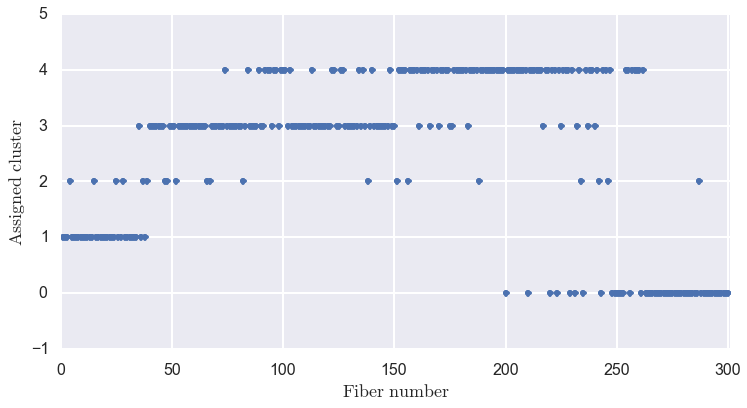

In [329]:
figsize(12,6)
bovy_plot.bovy_plot(numpy.arange(1,301),assigned,'.',
                   yrange=[-1.,5.],
                   xrange=[0.,301.],
                   xlabel=r'$\mathrm{Fiber\ number}$',
                   ylabel=r'$\mathrm{Assigned\ cluster}$')

In [331]:
print numpy.arange(1,301)[numpy.array(assigned) == 1]

[ 1  2  3  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 26 27 29
 30 31 32 33 34 36 38]


In [334]:
for gg in range(len(xmean)):
    indx= numpy.argmin((ydata[:,0]-xmean[gg,0])**2.+(ydata[:,1]-xmean[gg,1])**2.+(ydata[:,2]-xmean[gg,2])**2.)
    print gg, numpy.arange(1,301)[indx]

0 298
1 19
2 37
3 83
4 216


**So 4 good groupings appear to be: 1-38, 39-150,151-250,251-300, with good representative fibers for each group: 19, 83, 216, and 298**

# Using 4 groups

In [311]:
lnl, xamp, xmean, xcovar= run_xd(4,ydata,ycovar)
print lnl

3.4403615474


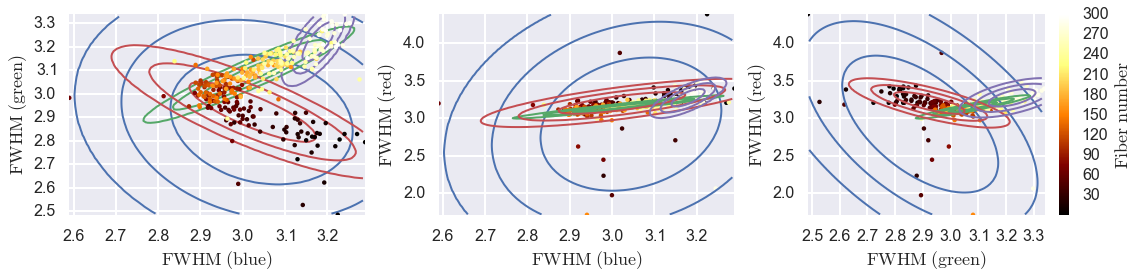

In [312]:
figsize(16,4)
subplot(1,3,1)
bovy_plot.bovy_plot(fwhm_blue,fwhm_green,c=numpy.arange(1,301),
                    edgecolor='none',scatter=True,
                    gcf=True,
                    cmap='afmhot',
                    xlabel=r'$\mathrm{FWHM\ (blue)}$',
                    ylabel=r'$\mathrm{FWHM\ (green)}$',
                   zorder=10)
x, y = np.mgrid[xlim()[0]:xlim()[1]:.01,ylim()[0]:ylim()[1]:.01]
pos = np.dstack((x, y))
for gg in range(len(xmean)):
    nm= stats.multivariate_normal(mean=xmean[gg,:2],cov=xcovar[gg,:2,:2])
    bovy_plot.bovy_dens2d(nm.pdf(pos).T,origin='lower',
                          xrange=[numpy.amin(x),numpy.amax(x)],
                          yrange=[numpy.amin(y),numpy.amax(y)],
                          justcontours=True,overplot=True,
                          cntrmass=True,
                          levels=special.erf(numpy.arange(1,4)/numpy.sqrt(2.)),
                          cntrcolors=colors.rgb2hex(sns.color_palette()[gg]),
                          zorder=gg)
subplot(1,3,2)
bovy_plot.bovy_plot(fwhm_blue,fwhm_red,c=numpy.arange(1,301),
                    edgecolor='none',scatter=True,
                    gcf=True,
                    cmap='afmhot',
                    xlabel=r'$\mathrm{FWHM\ (blue)}$',
                    ylabel=r'$\mathrm{FWHM\ (red)}$')
x, y = np.mgrid[xlim()[0]:xlim()[1]:.01,ylim()[0]:ylim()[1]:.01]
pos = np.dstack((x, y))
for gg in range(len(xmean)):
    nm= stats.multivariate_normal(mean=xmean[gg,::2],cov=xcovar[gg,::2,::2])
    bovy_plot.bovy_dens2d(nm.pdf(pos).T,origin='lower',
                          xrange=[numpy.amin(x),numpy.amax(x)],
                          yrange=[numpy.amin(y),numpy.amax(y)],
                          justcontours=True,overplot=True,
                          cntrmass=True,
                          levels=special.erf(numpy.arange(1,4)/numpy.sqrt(2.)),
                          cntrcolors=colors.rgb2hex(sns.color_palette()[gg]),
                          zorder=gg)
subplot(1,3,3)
bovy_plot.bovy_plot(fwhm_green,fwhm_red,c=numpy.arange(1,301),
                    edgecolor='none',scatter=True,
                    gcf=True,
                    colorbar=True,cmap='afmhot',
                    xlabel=r'$\mathrm{FWHM\ (green)}$',
                    ylabel=r'$\mathrm{FWHM\ (red)}$',
                    clabel=r'$\mathrm{Fiber\ number}$')
x, y = np.mgrid[xlim()[0]:xlim()[1]:.01,ylim()[0]:ylim()[1]:.01]
pos = np.dstack((x, y))
for gg in range(len(xmean)):
    nm= stats.multivariate_normal(mean=xmean[gg,1:],cov=xcovar[gg,1:,1:])
    bovy_plot.bovy_dens2d(nm.pdf(pos).T,origin='lower',
                          xrange=[numpy.amin(x),numpy.amax(x)],
                          yrange=[numpy.amin(y),numpy.amax(y)],
                          justcontours=True,overplot=True,
                          cntrmass=True,
                          levels=special.erf(numpy.arange(1,4)/numpy.sqrt(2.)),
                          cntrcolors=colors.rgb2hex(sns.color_palette()[gg]),
                          zorder=gg)
tight_layout()

In [313]:
prob= numpy.empty((300,len(xmean)))
for gg in range(len(xmean)):
    for ii in range(300):
        nm= stats.multivariate_normal(mean=xmean[gg],cov=xcovar[gg]+ycovar[ii])
        prob[ii,gg]= numpy.log(xamp[gg])+nm.logpdf(ydata[ii])
for ii in range(300): prob[ii]-= misc.logsumexp(prob[ii])
prob= numpy.exp(prob)
assigned= [numpy.arange(len(xmean))[numpy.argmax(p)] for p in prob]

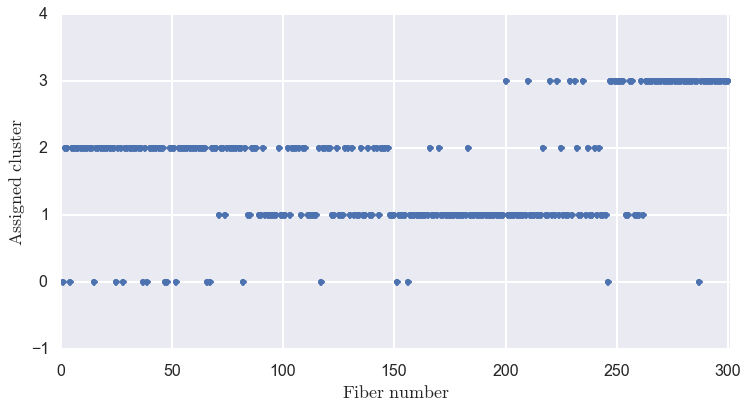

In [314]:
figsize(12,6)
bovy_plot.bovy_plot(numpy.arange(1,301),assigned,'.',
                   yrange=[-1.,4.],
                   xrange=[0.,301.],
                   xlabel=r'$\mathrm{Fiber\ number}$',
                   ylabel=r'$\mathrm{Assigned\ cluster}$')

# Using 3 groups

In [270]:
lnl, xamp, xmean, xcovar= run_xd(3,ydata,ycovar)

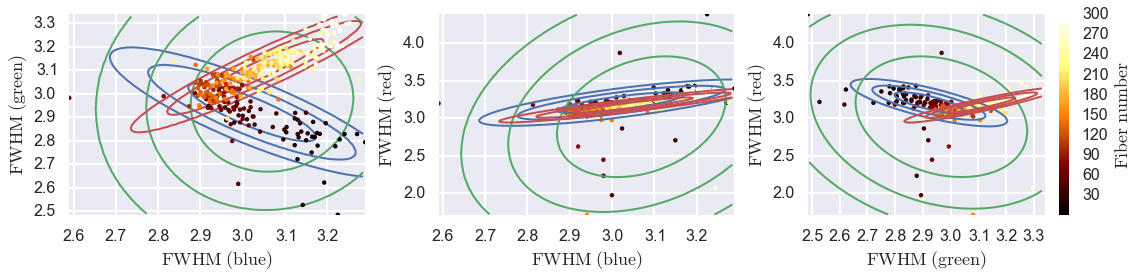

In [271]:
figsize(16,4)
subplot(1,3,1)
bovy_plot.bovy_plot(fwhm_blue,fwhm_green,c=numpy.arange(1,301),
                    edgecolor='none',scatter=True,
                    gcf=True,
                    cmap='afmhot',
                    xlabel=r'$\mathrm{FWHM\ (blue)}$',
                    ylabel=r'$\mathrm{FWHM\ (green)}$',
                   zorder=10)
x, y = np.mgrid[xlim()[0]:xlim()[1]:.01,ylim()[0]:ylim()[1]:.01]
pos = np.dstack((x, y))
for gg in range(len(xmean)):
    nm= stats.multivariate_normal(mean=xmean[gg,:2],cov=xcovar[gg,:2,:2])
    bovy_plot.bovy_dens2d(nm.pdf(pos).T,origin='lower',
                          xrange=[numpy.amin(x),numpy.amax(x)],
                          yrange=[numpy.amin(y),numpy.amax(y)],
                          justcontours=True,overplot=True,
                          cntrmass=True,
                          levels=special.erf(numpy.arange(1,4)/numpy.sqrt(2.)),
                          cntrcolors=colors.rgb2hex(sns.color_palette()[gg]),
                          zorder=gg)
subplot(1,3,2)
bovy_plot.bovy_plot(fwhm_blue,fwhm_red,c=numpy.arange(1,301),
                    edgecolor='none',scatter=True,
                    gcf=True,
                    cmap='afmhot',
                    xlabel=r'$\mathrm{FWHM\ (blue)}$',
                    ylabel=r'$\mathrm{FWHM\ (red)}$')
x, y = np.mgrid[xlim()[0]:xlim()[1]:.01,ylim()[0]:ylim()[1]:.01]
pos = np.dstack((x, y))
for gg in range(len(xmean)):
    nm= stats.multivariate_normal(mean=xmean[gg,::2],cov=xcovar[gg,::2,::2])
    bovy_plot.bovy_dens2d(nm.pdf(pos).T,origin='lower',
                          xrange=[numpy.amin(x),numpy.amax(x)],
                          yrange=[numpy.amin(y),numpy.amax(y)],
                          justcontours=True,overplot=True,
                          cntrmass=True,
                          levels=special.erf(numpy.arange(1,4)/numpy.sqrt(2.)),
                          cntrcolors=colors.rgb2hex(sns.color_palette()[gg]),
                          zorder=gg)
subplot(1,3,3)
bovy_plot.bovy_plot(fwhm_green,fwhm_red,c=numpy.arange(1,301),
                    edgecolor='none',scatter=True,
                    gcf=True,
                    colorbar=True,cmap='afmhot',
                    xlabel=r'$\mathrm{FWHM\ (green)}$',
                    ylabel=r'$\mathrm{FWHM\ (red)}$',
                    clabel=r'$\mathrm{Fiber\ number}$')
x, y = np.mgrid[xlim()[0]:xlim()[1]:.01,ylim()[0]:ylim()[1]:.01]
pos = np.dstack((x, y))
for gg in range(len(xmean)):
    nm= stats.multivariate_normal(mean=xmean[gg,1:],cov=xcovar[gg,1:,1:])
    bovy_plot.bovy_dens2d(nm.pdf(pos).T,origin='lower',
                          xrange=[numpy.amin(x),numpy.amax(x)],
                          yrange=[numpy.amin(y),numpy.amax(y)],
                          justcontours=True,overplot=True,
                          cntrmass=True,
                          levels=special.erf(numpy.arange(1,4)/numpy.sqrt(2.)),
                          cntrcolors=colors.rgb2hex(sns.color_palette()[gg]),
                          zorder=gg)
tight_layout()

In [272]:
prob= numpy.empty((300,len(xmean)))
for gg in range(len(xmean)):
    for ii in range(300):
        nm= stats.multivariate_normal(mean=xmean[gg],cov=xcovar[gg]+ycovar[ii])
        prob[ii,gg]= numpy.log(xamp[gg])+nm.logpdf(ydata[ii])
for ii in range(300): prob[ii]-= misc.logsumexp(prob[ii])
prob= numpy.exp(prob)
assigned= [numpy.arange(len(xmean))[numpy.argmax(p)] for p in prob]

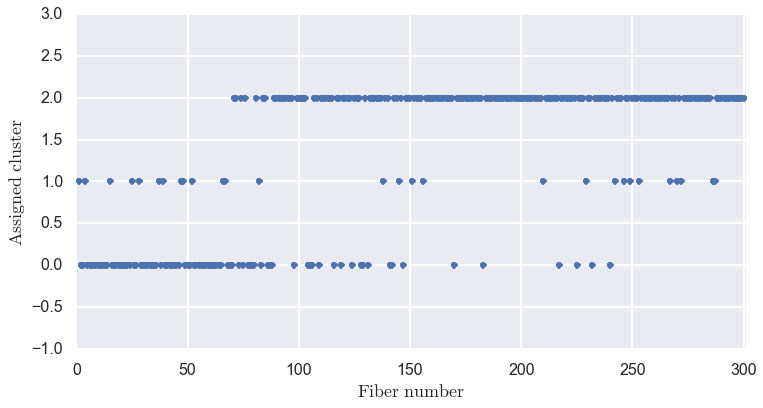

In [274]:
figsize(12,6)
bovy_plot.bovy_plot(numpy.arange(1,301),assigned,'.',
                   yrange=[-1.,3.],
                   xrange=[0.,301.],
                   xlabel=r'$\mathrm{Fiber\ number}$',
                   ylabel=r'$\mathrm{Assigned\ cluster}$')